<a href="https://colab.research.google.com/github/ravit-cohen-segev/cats/blob/master/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

# New Section

In [ ]:

downloaded = drive.CreateFile({'id':"seq2seq_GAN"})

In [ ]:
#install rdkit (for reading smiles from mol file)
!pip install kora
import kora.install.rdkit


In [ ]:
!pip install sklearn


In [ ]:
import rdkit.Chem

import tensorflow as tf
from tensorflow.keras.layers import Embedding, LeakyReLU, Add, Concatenate, Activation, Dense, BatchNormalization, LSTM, Input, Concatenate, LeakyReLU
from tensorflow.keras.models import model_from_json
from tensorflow.keras import Model, Sequential, losses, initializers, regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam, Adagrad, SGD

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
from joblib import load, dump

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
import random




smiles_vocab = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'V', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                't', 'u', 'None']
max_len = 100
latent_dim = 64
len_vocab=57

#create new generated molecules
class Generator:
    def __init__(self, max_len=100, len_vocab=57):
        self.max_len = max_len
        self.len_vocab = len_vocab

    #create fake onehots with rules: smiles must start with a letter. closing brackets will not appear before opening brackets
    def create_onehot_mat_random(self, sample_num):
        #list of characters to exclude if there isn't an opening bracket of if another type of bracket is already open
        exclude_ch = ['(', ')', '[', ']']

        onehot_mat = np.zeros((sample_num, self.max_len, self.len_vocab))
        minimum_size_mol = 20
        min_end_chain = 1
        max_end_chain = self.max_len - minimum_size_mol

        # create array of indices that point only to letters in smiles_vocab. This is for the first letter of smile
        first_lett_1 = np.arange(21, 39)
        first_lett_2 = np.arange(42, 56)
        first_lett_comb = np.append(first_lett_1, first_lett_2)

        for i in range(sample_num):
            random_end_len = np.random.randint(min_end_chain, max_end_chain)
            #first random letter
            r1 = np.random.choice(first_lett_comb,1)
            onehot_mat[i, 0] = np.eye(self.len_vocab)[r1]

            open_brackets_count = 0
            open_square_brackets_count = 0

            for j in range(1, max_len - random_end_len - 1): #start from second character
                allowed_ch = np.arange(self.len_vocab)

                # can't use close brackets if there isn't an open brackets before
                if open_brackets_count == 0:
                    allowed_ch = np.setdiff1d(allowed_ch, 4)
                else:
                    allowed_ch = np.setdiff1d(allowed_ch, (39, 41))  # make only one type of brackets is open

                if open_square_brackets_count == 0:
                    allowed_ch = np.setdiff1d(allowed_ch, 41)
                else:
                    allowed_ch = np.setdiff1d(allowed_ch, (3, 4))  # make only one type of brackets is open

                r = np.random.choice(allowed_ch)
                # if character is already a bracket, continue searching for a position that is not a bracket
                while smiles_vocab[np.argmax(onehot_mat[i, j])] in exclude_ch:
                    r = np.random.choice(allowed_ch)

                onehot_mat[i, j, :] = np.eye(self.len_vocab)[r]

                if smiles_vocab[r] == ')':
                    open_brackets_count -= 1

                if smiles_vocab[r] == ']':
                    open_square_brackets_count -=1 
                if smiles_vocab[r] == '(':
                    open_brackets_count += 1
                    o_bracket_p0 = j

                if smiles_vocab[r] == '[':
                    open_square_brackets_count += 1

        new_end = random_end_len

        for col in range(self.max_len - new_end, self.max_len):
            onehot_mat[i, col, -1] = 1

        return onehot_mat

#create autoencoder
class Decoder_seq2seq_VAE:
    def __init__(self, max_len=100):
        self.max_len = max_len
        self.vocab = smiles_vocab
        # for adding a positional feature
        self.smi2index = dict((c, i) for i, c in enumerate(self.vocab))

    def smiles_to_onehot_mat(self, smiles):
        len_vocab = len(self.vocab)
        onehot_mat = []
        for smile in smiles:
            m = rdkit.Chem.MolFromSmiles(smile, sanitize=False)
            if m is None:
                onehot_mat.append(np.nan)
            else:
                smile = rdkit.Chem.MolToSmiles(m)
                x = np.zeros((self.max_len, len_vocab))

                c_i = 0
                for idx, c in enumerate(smile):
                    x[idx, self.smi2index[c]] = 1
                    c_i = idx
                # if smile is smaller than max_len than the remaining indices of chars will be equal to the index of none in vocab
                while c_i < (self.max_len - 1):
                    c_i += 1
                    x[idx, self.smi2index['None']] = 1
                onehot_mat.append(x)
        #return np.asarray(onehot_mat, dtype=np.int8)
        return np.asarray(onehot_mat, dtype=np.float16)

    def smiles_decoder(self, output):
        index2smi = dict((i, c) for i, c in enumerate(self.vocab))
        decoded_smiles = []
        for row in range(len(output)):
            smi = ''
            for i in range(len(output[row])):
                atom_idx = output[row, i, :].argmax(axis=-1)
                if index2smi[atom_idx]!='None':
                   smi = smi + index2smi[atom_idx]
                else:
                    break
            decoded_smiles.append(smi)
        return decoded_smiles

    def build_encoder_decoder_model(self, max_len, input_shape, latent_dim, optimization):

        lstm_units = 64
        kernel_regularizer = regularizers.l2(1e-5)

        encoder_input = Input(shape=input_shape, name='Input_encoder')
        lstm_encoder = LSTM(lstm_units, return_sequences=True, activation='relu', name='lstm_encoder')(encoder_input)
        encoder_output = Dense(latent_dim, activation='relu', name='Dense_encoder')(lstm_encoder)

        encoder = Model(encoder_input, encoder_output, name="encoder")

        decoder_input = Input(shape=(max_len, latent_dim), name='decoder_input')
        decoder_batch = BatchNormalization()(decoder_input)
        decoder_output = LSTM(len(smiles_vocab), kernel_regularizer=kernel_regularizer, return_sequences=True,
                            activation='softmax', name='lstm_decoder')(decoder_batch)
        decoder = Model(decoder_input, decoder_output, name="decoder")

        x = encoder(encoder_input)
        output = decoder(x)

        autoencoder_model = Model(encoder_input, output, name="autoencoder")
        loss_fn = losses.CategoricalCrossentropy()


        autoencoder_model.compile(loss=loss_fn, optimizer=optimization,
                                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
        return autoencoder_model

    def train_autoencoder(self, files_per_iter, end_file, batches, epochs, latent_dim, optimization) -> object:
        m = True
        for epoch in range(epochs):
           print("epoch num is:", epoch)
           i = 0
           while i<end_file:
              y_train, y_train_onehot = prepare_data(i, i+files_per_iter)
              new_dim = y_train_onehot.shape
              input_shape = (new_dim[1], new_dim[2])
              if m:
                 autoencoder = self.build_encoder_decoder_model(max_len, input_shape, latent_dim, optimization)
                 m = False
              i += files_per_iter
              autoencoder.fit(y_train_onehot, y_train_onehot, batch_size = batches)
        serialize_to_json(autoencoder, 'autoencoder')
        return autoencoder
    
class Discriminator:
    def __init__(self, max_len=100, len_vocab=57):
        self.max_len = max_len
        self.len_vocab = len_vocab

    

    def compile_discriminator(self, optimizer):
        '''json_file = open("autoencoder.json", 'r')
        loaded_model = json_file.read()
        json_file.close()
        autoencoder = model_from_json(loaded_model)
        autoencoder.load_weights("autoencoder.h5")
        #set_weights from last layer of autoencoder
        #w = autoencoder.layers[-1].get_weights()'''
        input_shape = (self.max_len, self.len_vocab)
        #discriminator_model = Sequential()
        #discriminator_model.add(Input(shape=input_shape))
        kernel_regularizer = regularizers.l2(1e-5)

        input_D = Input(shape=input_shape)
        lstm1_D = LSTM(16, kernel_initializer=initializers.RandomNormal(), kernel_regularizer=kernel_regularizer,
                       return_sequences=True, activation='relu')(input_D)

        lstm2_D = LSTM(16, kernel_initializer=initializers.RandomNormal(), kernel_regularizer=kernel_regularizer,
                       activation='relu')(lstm1_D)
        batch = BatchNormalization()(lstm2_D)
        output_D = Dense(1, kernel_regularizer=kernel_regularizer,
                         activation='sigmoid')(batch)
        discriminator_model = Model(inputs=input_D, outputs=output_D, name="Discriminator")
        discriminator_model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        return discriminator_model

    def train_discriminator(self, t_data, labels, batches, epochs, optimizer=SGD(0.00001)):
        model = self.compile_discriminator(optimizer)
        model.fit(t_data, labels, batch_size=batches, epochs=epochs)
        serialize_to_json(model, 'Discriminator')
        return model

    def create_data_for_discriminator(self, file_ix):
        y_arr, y_onehot = load_data(file_ix, max_len)
        labels_true = np.ones((len(y_onehot),1))

        #create fake data
        gen = Generator()
        y_fake = gen.create_onehot_mat_random(len(y_onehot))
        labels_false = np.zeros((len(y_onehot),1))

        #combine to one dataset
        data = np.concatenate((y_onehot, y_fake))
        labels =  np.concatenate((labels_true, labels_false))
        #shuffle rows
        shuffled_data, shuffled_labels = shuffle(data, labels, random_state=0)
        return shuffled_data, shuffled_labels


class ZincGAN():
    def __init__(self):
        self.Autoencoder = load_model_from_file("autoencoder")

        self.Discriminator = Discriminator().compile_discriminator(optimizer=SGD(0.001))
        self.l = 21184
        self.len_vocab = len_vocab

    def config_model(self, model, target_model):
        weights = model.get_weights()
        target_model.set_weights(weights)
        return

    def custom_generator_loss(self, y_true, y_pred):
        #  Disc_pred = self.Discriminator.predict(y_pred)
        D_mse_loss = K.sqrt(K.square(y_pred - y_true))
        loss = K.log(1 - D_mse_loss)
        return loss

    def build_combined_gan(self, optimizer=SGD(0.001)):
        # make weights in the discriminator not trainable
        self.Discriminator.trainable = False
        self.combined = Sequential()
        # combine the models

        inputs = self.Autoencoder.input
        inter = self.Autoencoder(inputs)
        outputs = self.Discriminator(inter)

        #    input = self.Autoencoder(inputs)
        #   out = self.Discriminator(input)

        self.combined = Model(inputs=inputs, outputs=outputs, name="gan_model")
        # compile
        self.combined.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
        return self.combined

    def train_GAN(self, latent_dim=57, n_batch=128, epochs=500, total_files=20):
        steps_per_epoch = int(self.l / n_batch)

        history_loss_g = []
        history_acc_g = []
        history_loss_d = []
        history_acc_d = []
        history = History()
        # compile combine model
        self.build_combined_gan()
        #config autoencoder weights with gan nn

        self.config_model(self.Autoencoder, self.combined.layers[1])
        for epoch in range(epochs):
            print("{} epoch/ {} epochs".format(epoch, epochs))
            #        for j in range(batches):
            gc.collect()
            # print("{} batch/ {} batches".format(j, batches))
            # create fake onehots
            fake_data = create_fake_onehots(self.l)
            generated_data = self.Autoencoder.predict(fake_data)
            labels_false = np.zeros((self.l, 1))

            # choose random molecules from dataset (real samples)
            file_ix = np.random.randint(total_files)
            y_arr, real_data = load_data(file_ix, max_len)
            labels_true = np.ones((self.l, 1))

            x_generator = np.vstack((real_data, generated_data))
            y_generator = np.vstack((labels_true, labels_false))
            D_generator = [x_generator, y_generator]

            # x_validation = np.vstack((real_data[20000:], fake_data[20000:]))
            # y_validation = np.vstack((labels_true[20000:], labels_false[20000:]))
            #            D_validation = [x_validation,y_validation]

            #       D_partition = {'train':x_generator, 'test':x_validation}

            # update discriminator model weights
            print("Train Discriminator")
            #     before = self.Discriminator.predict(x_generator)
            h_d = self.Discriminator.fit(x_generator, y_generator, batch_size=steps_per_epoch, epochs=1,
                                         callbacks=[history])
            #    after = self.Discriminator.predict(x_generator)
            #   merged = np.hstack((before, after, y_generator))
            # configure Discriminator weights between both models
            self.config_model(self.Discriminator, self.combined.layers[-1])

            # create random onehots for gan
            x_gan = create_fake_onehots(self.l * 2)
            # create inverse labels for the fake data
            y_gan = np.ones((self.l * 2, 1))
            # update the generator via the discriminator error

            gan_generator = [x_gan, y_gan]
            #       gan_validation = [x_gan[20000:], y_gan[20000:]]

            #       G_partition = {'train':gan_generator, 'test':gan_validation}
            print("Train Gan")

            h_g = self.combined.fit(x_gan, y_gan, batch_size=steps_per_epoch, epochs=1, callbacks=[history])
            #configure autoencoder weights
            self.config_model(self.combined.layers[1], self.Autoencoder)

            history_loss_d.append(h_d.history['loss'])
            history_acc_d.append(h_d.history['accuracy'])
            history_loss_g.append(h_g.history['loss'])
            history_acc_g.append(h_g.history['accuracy'])
            cutoff = 0.9
            print("END of epoch:", epoch)
            
            #save generator model every 10 epochs
            if epoch%10 == 0:
               serialize_to_json(self.Autoencoder, 'generator')
        serialize_to_json(self.combined, 'gan')
        return self.combined, self.Discriminator, history_loss_g, history_acc_g, history_loss_d, history_acc_d

#functions outside classes
def generator_predict(self, sample_num):
   json_file = open("autoencoder.json", 'r')
   loaded_model = json_file.read()
   json_file.close()
   autoencoder = model_from_json(loaded_model)
   autoencoder.load_weights("autoencoder.h5")
   onehot_input = self.create_onehot_mat_random(sample_num)
   pred = autoencoder.predict(onehot_input)
   dec = Decoder_seq2seq_VAE()
   onehot = dec.smiles_decoder(pred)
   return onehot

#load saved data
def prepare_data(start, end):
   for i in range(start, end):
      temp_y, temp_onehot = load_data(i, max_len)
      if i==start:
         y_arr = temp_y
         y_onehot = temp_onehot
      else:
         y_arr = np.concatenate((y_arr, temp_y), axis=0)
         y_onehot = np.concatenate((y_onehot, temp_onehot), axis=0)
   return y_arr, y_onehot

#save weights 
def weights_to_file(model):
    g_w = {}
    for i, layer in enumerate(model.layers):
        g_w['w' + str(i)] = layer.get_weights()

    with open('weights.txt', 'w') as file:
        for item in g_w.keys():
            file.write(str(g_w[item]))
    return

#print predictions to file
def pred_to_file(y_pred, type_label):
    with open(type_label + '.txt', 'w') as file:
        for val in y_pred:
            file.write(str(val) + '\n')
    return


def load_file(file_name):
    temp = np.load(r"C:\Users\ravit\PycharmProjects\Barak_BGU\data\data_for_keras0.npy", allow_pickle=True)
    return temp

def load_data(i, max_len):
    path = r"/content/drive/My Drive/pycharm/seq2seq_GAN/data/"
    label_file = path + "data_for_keras" + "label" + str(i) + ".txt"

    with open(label_file) as label:
        y_arr = label.readlines()
        smi = Decoder_seq2seq_VAE()
        y_onehot = smi.smiles_to_onehot_mat(y_arr)
    return y_arr, y_onehot

#save model layers and weights in json files
def serialize_to_json(model, name):
    model_json = model.to_json()
    with open(name+".json", 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(name+".h5")
    return


def load_model_from_file(model_name):
    json_file = open(r"/content/drive/My Drive/pycharm/seq2seq_GAN/" + model_name + ".json", 'r')
    loaded_model = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model)
    model.load_weights(r"/content/drive/My Drive/pycharm/seq2seq_GAN/" + model_name + ".h5")
    return model


def create_fake_onehots(l):
    gen = Generator()
    y_fake = gen.create_onehot_mat_random(l)
    return y_fake


def generator_input_output(l, gan_model):
    generator = Sequential()
    generator.add(gan_model.layers[0])
    x = create_fake_onehots(l)
    y_pred = generator.predict(x)
    dec = Decoder_seq2seq_VAE()
    smi_res = dec.smiles_decoder(y_pred)
    #print results
    print(smi_res)
    
    #save to file
    for i, line in enumerate(smi_res):
      with open(epochs+"epochs_generated_mols.txt", 'w') as f:
         f.writelines(smi_res)
         f.close()
    return 

def plot_history(le, h_loss_g, h_acc_g, h_loss_d, h_acc_d):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # summarize history for accuracy
    ax1.plot(np.arange(le), history_acc_g, 'r')
    ax1.plot(np.arange(le), history_acc_d, 'g')
    ax1.set_title('accuracy_over_time')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epochs')

    # summarize history for loss

    ax2.plot(np.arange(200), history_loss_g, 'r')
    ax2.plot(np.arange(200), history_loss_d, 'g')
    ax2.set_title('loss_over_time')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epochs')

    plt.ylim(0, 5)
    fig.show()
    return

def predict_autoencoder(n, epochs, discriminator_model):
    autoencoder = load_model_from_file('generator')
    a_data = create_fake_onehots(n)
    gen_pred = autoencoder.predict(a_data)
    gen = Decoder_seq2seq_VAE()
    decoded = gen.smiles_decoder(gen_pred)
    y_disc = discriminator_model.predict(gen_pred)
    pred_to_file(y_disc, str(epochs) + 'num_epochs')
    return decoded, y_disc




if __name__ == "__main__":
    # check GPU available

    print('Version of tensorflow:\n', tf.__version__)
    print("GPU Available:", tf.config.list_physical_devices('GPU'))

    if tf.test.is_gpu_available():
        device_name = tf.test.gpu_device_name()
    else:
        device_name = '/CPU:0'
    print(device_name)

    epochs = 150
    gan = ZincGAN()
    gan_model, discriminator_model, history_loss_g, history_acc_g, history_loss_d, history_acc_d \
        = gan.train_GAN(n_batch=128, epochs=epochs, total_files=20)

    plot_history(epochs, history_loss_g, history_acc_g, history_loss_d, history_acc_d)
  


Version of tensorflow:
 2.3.0
GPU Available: []
/CPU:0
0 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 11s - loss: 0.2503 - accuracy: 0.1212WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.0841s). Check your callbacks.


257/257 [==============================] - 19s 73ms/step - loss: 0.2495 - accuracy: 0.9012
Train Gan
  2/257 [..............................] - ETA: 32s - loss: 0.6933 - accuracy: 0.6182WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0011s vs `on_train_batch_end` time: 0.2511s). Check your callbacks.


257/257 [==============================] - 61s 237ms/step - loss: 0.6933 - accuracy: 0.6512
END of epoch: 0
1 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 9s - loss: 0.2498 - accuracy: 0.8727WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0042s vs `on_train_batch_end` time: 0.0705s). Check your callbacks.


257/257 [==============================] - 18s 72ms/step - loss: 0.2498 - accuracy: 0.8897
Train Gan
  2/257 [..............................] - ETA: 29s - loss: 0.6937 - accuracy: 0.4182WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_train_batch_end` time: 0.2256s). Check your callbacks.


257/257 [==============================] - 60s 235ms/step - loss: 0.6935 - accuracy: 0.5181
END of epoch: 1
2 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 9s - loss: 0.2498 - accuracy: 0.8667WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_train_batch_end` time: 0.0643s). Check your callbacks.


257/257 [==============================] - 18s 70ms/step - loss: 0.2499 - accuracy: 0.9101
Train Gan
  2/257 [..............................] - ETA: 28s - loss: 0.6937 - accuracy: 0.5152WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0082s vs `on_train_batch_end` time: 0.2126s). Check your callbacks.


257/257 [==============================] - 60s 234ms/step - loss: 0.6934 - accuracy: 0.6326
END of epoch: 2
3 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 9s - loss: 0.2499 - accuracy: 0.9758WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0013s vs `on_train_batch_end` time: 0.0695s). Check your callbacks.


257/257 [==============================] - 18s 69ms/step - loss: 0.2499 - accuracy: 0.7910
Train Gan
  2/257 [..............................] - ETA: 28s - loss: 0.6937 - accuracy: 0.0515WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0089s vs `on_train_batch_end` time: 0.2073s). Check your callbacks.


257/257 [==============================] - 60s 235ms/step - loss: 0.6936 - accuracy: 0.1198
END of epoch: 3
4 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 9s - loss: 0.2499 - accuracy: 0.9909WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.0715s). Check your callbacks.


257/257 [==============================] - 18s 71ms/step - loss: 0.2499 - accuracy: 0.9795
Train Gan
  2/257 [..............................] - ETA: 28s - loss: 0.6938 - accuracy: 0.0515WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.2151s). Check your callbacks.


257/257 [==============================] - 60s 232ms/step - loss: 0.6936 - accuracy: 0.0600
END of epoch: 4
5 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 9s - loss: 0.2500 - accuracy: 0.9818WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.0700s). Check your callbacks.


257/257 [==============================] - 18s 70ms/step - loss: 0.2500 - accuracy: 0.8373
Train Gan
  2/257 [..............................] - ETA: 29s - loss: 0.6937 - accuracy: 0.0273WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0120s vs `on_train_batch_end` time: 0.2178s). Check your callbacks.


257/257 [==============================] - 60s 232ms/step - loss: 0.6937 - accuracy: 0.0305
END of epoch: 5
6 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 8s - loss: 0.2500 - accuracy: 0.9788WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0011s vs `on_train_batch_end` time: 0.0674s). Check your callbacks.


257/257 [==============================] - 18s 68ms/step - loss: 0.2500 - accuracy: 0.9624
Train Gan
  2/257 [..............................] - ETA: 31s - loss: 0.6938 - accuracy: 0.0091WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0215s vs `on_train_batch_end` time: 0.2206s). Check your callbacks.


257/257 [==============================] - 60s 234ms/step - loss: 0.6939 - accuracy: 0.0043
END of epoch: 6
7 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 9s - loss: 0.2500 - accuracy: 0.9788WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


257/257 [==============================] - 17s 66ms/step - loss: 0.2500 - accuracy: 0.7977
Train Gan
  2/257 [..............................] - ETA: 28s - loss: 0.7056 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0033s vs `on_train_batch_end` time: 0.2172s). Check your callbacks.


257/257 [==============================] - 60s 232ms/step - loss: 0.7056 - accuracy: 0.0000e+00
END of epoch: 7
8 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 8s - loss: 0.2500 - accuracy: 0.9848WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0069s vs `on_train_batch_end` time: 0.0547s). Check your callbacks.


257/257 [==============================] - 18s 71ms/step - loss: 0.2500 - accuracy: 0.9823
Train Gan
  2/257 [..............................] - ETA: 29s - loss: 0.6956 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0077s vs `on_train_batch_end` time: 0.2232s). Check your callbacks.


257/257 [==============================] - 59s 231ms/step - loss: 0.6955 - accuracy: 0.0000e+00
END of epoch: 8
9 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 9s - loss: 0.2500 - accuracy: 0.9909WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0013s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


257/257 [==============================] - 18s 70ms/step - loss: 0.2500 - accuracy: 0.8923
Train Gan
  2/257 [..............................] - ETA: 29s - loss: 0.6939 - accuracy: 0.0030WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0115s vs `on_train_batch_end` time: 0.2196s). Check your callbacks.


257/257 [==============================] - 60s 232ms/step - loss: 0.6939 - accuracy: 0.0052
END of epoch: 9
10 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 8s - loss: 0.2500 - accuracy: 0.9848WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0634s). Check your callbacks.


257/257 [==============================] - 18s 69ms/step - loss: 0.2500 - accuracy: 0.7469
Train Gan
  2/257 [..............................] - ETA: 28s - loss: 0.6934 - accuracy: 0.2424WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0023s vs `on_train_batch_end` time: 0.2164s). Check your callbacks.


257/257 [==============================] - 59s 231ms/step - loss: 0.6934 - accuracy: 0.3070
END of epoch: 10
11 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 9s - loss: 0.2500 - accuracy: 0.9788WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0056s vs `on_train_batch_end` time: 0.0629s). Check your callbacks.


257/257 [==============================] - 18s 70ms/step - loss: 0.2500 - accuracy: 0.7413
Train Gan
  2/257 [..............................] - ETA: 30s - loss: 0.6935 - accuracy: 0.0485WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0036s vs `on_train_batch_end` time: 0.2290s). Check your callbacks.


257/257 [==============================] - 60s 232ms/step - loss: 0.6935 - accuracy: 0.1410
END of epoch: 11
12 epoch/ 150 epochs
Train Discriminator
  2/257 [..............................] - ETA: 9s - loss: 0.2500 - accuracy: 0.9909WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0052s vs `on_train_batch_end` time: 0.0698s). Check your callbacks.


257/257 [==============================] - 18s 70ms/step - loss: 0.2500 - accuracy: 0.9629


In [ ]:
generator = Sequential()
generator.add(gan_model.layers[0])
x = create_fake_onehots(1000)
y_pred = generator.predict(x)
dec = Decoder_seq2seq_VAE()
smi_res = dec.smiles_decoder(y_pred)
with open(str(epochs)+"epochs_generated_mols.txt", 'w') as f:
   print(str(smi_res), file=f)


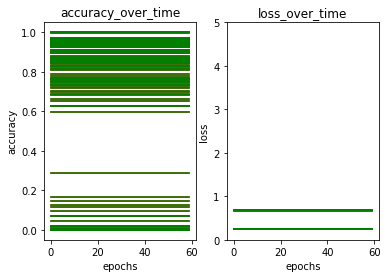

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# summarize history for accuracy
ax1.plot(np.arange(epochs), history_acc_g, 'r')
ax1.plot(np.arange(epochs), history_acc_d, 'g')
ax1.set_title('accuracy_over_time')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epochs')

# summarize history for loss

ax2.plot(np.arange(epochs), history_loss_g, 'r')
ax2.plot(np.arange(epochs), history_loss_d, 'g')
ax2.set_title('loss_over_time')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')

plt.ylim(0, 5)
fig.show()
    
